In [1]:
import os
import json
from glob import glob
from collections import Counter
import sys
sys.path.insert(0, '../')

import networkx as nx

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from modules.load_data import load

read 데이터로부터 유저가 조회한 글들을 시퀀스 형태로 받아볼 수 있음.  
시퀀스를 바탕으로 그래프를 그려보면 각각의 글 간에 관계성을 구해볼 수 있지 않을까?  
metadata에서는 post_id에 따른 태그 목록(keyword_list)를 얻어볼 수 있음  
그래프를 그릴 수 있다면, 각 post_id의 태그 정보를 attribute로 삼아 GNN을 구현할 수 있지 않을까?

In [3]:
read = load(name='read')
post_sequences = read['sequence'].tolist()

metadata의 keyword_list를 활용한 태그 간 유사성 파악
- TF-IDF 활용
- 작가별 character를 알아볼 수도 있겠는데?

In [4]:
metadata_raw = load('metadata')

태그가 하나라도 있는 글

In [18]:
# metadata_kwd = metadata_raw[metadata_raw['keyword_list'].apply(lambda x: len(x) > 0)].reset_index(drop=True)['keyword_list']
metadata_kwd = metadata_raw[metadata_raw['keyword_list'].apply(lambda x: len(x) > 0)].reset_index(drop=True) # 태그가 하나라도 있는 글

[['여행', '호주', '국립공원'],
 ['목련꽃', '아지랑이', '동행'],
 ['감정', '마음', '위로'],
 ['유럽여행', '더블린', '아일랜드'],
 ['석유에너지', '베네수엘라', '경제']]

In [28]:
def squeeze(arr: list) -> list:
    '''2차원 리스트를 1차원으로 squeeze'''
    result = []
    for l in arr:
        if len(l) > 0 and isinstance(l, list):
            result.extend(l)
        elif not isinstance(l, list):
            result.append(l)
    return result
        
num_tags = len(set(squeeze(metadata_kwd['keyword_list'].tolist())))
print(f'태그 종류 수: {num_tags:,d}')

태그 종류 수: 86,037


In [29]:
# kwd_frequency = pd.Series(Counter(squeeze(metadata_kwd))).sort_values(ascending=False)
kwd_frequency = pd.Series(Counter(squeeze(metadata_kwd['keyword_list']))).sort_values(ascending=False)

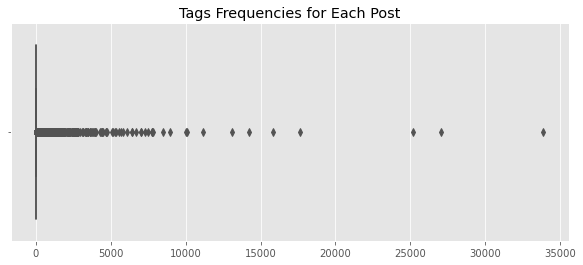

In [31]:
plt.figure(figsize=(10, 4))
sns.boxplot(kwd_frequency.values)
plt.title('Tags Frequencies for Each Post')
plt.show()

In [34]:
kwd_cumul_freq = kwd_frequency.to_frame('freq')[::-1].cumsum().reset_index()
kwd_density = kwd_frequency / kwd_frequency.sum()
kwd_cumul_density = kwd_density.to_frame('density')[::-1].cumsum().reset_index()

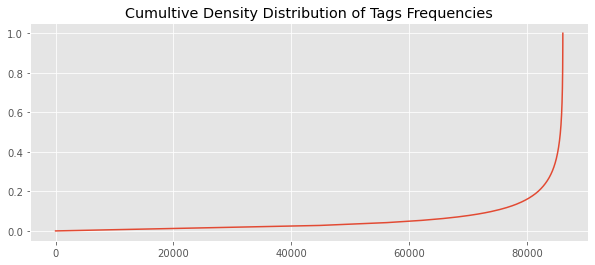

In [35]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=kwd_cumul_density.index.tolist(), y=kwd_cumul_density['density'].tolist())
plt.title('Cumultive Density Distribution of Tags Frequencies')
plt.show()

In [36]:

TOP_N = 7000
print(f'상위 {TOP_N}개 태그가 전체 태그 중 차지하는 비율: {kwd_frequency.head(TOP_N).sum() / kwd_frequency.sum()}')


상위 7000개 태그가 전체 태그 중 차지하는 비율: 0.8536076380940615


7000개 태그를 활용하여 TF-IDF를 산출해봅시다

In [37]:
vocabulary = kwd_frequency.head(7000).index.tolist()

In [60]:
kwd_frequency.reset_index().rename({'index':'tag', 0:'freq'}, axis=1).head(7000).to_csv('../raw/tag_vocab7000.csv', index=False)

In [38]:
def filter_tags(tag_list: list, vocabulary: list) -> list:
    '''metadata 내 태그 리스트(keyword_list)의 태그 목록 중 vocabulary에 있는 태그만을 남기고 나머지는 제거하는 함수
    metadata['keyword_list'].apply(lambda x: filter_tags(x, vocabulary))
    '''
    result = []
    for tag in tag_list:
        if tag in vocabulary:
            result.append(tag)
    return result

In [39]:
# metadata_kwd_filtered = metadata_kwd.apply(lambda x: filter_tags(x, vocabulary))
metadata_kwd['keyword_list'] = metadata_kwd['keyword_list'].apply(lambda x: filter_tags(x, vocabulary))

In [40]:
# metadata_kwd_filtered.head()
metadata_kwd.head()

,magazine_id,user_id,title,keyword_list,display_url,sub_title,reg_ts,article_id,post_id
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782
1,12081,@kohwang56,[시] 서러운 봄,[동행],https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81
2,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88
3,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34
4,17646,@jordan777,"지식·기술이 가장 경쟁력 있는 자원이다 ""","[베네수엘라, 경제]",https://brunch.co.kr/@jordan777/1334,,1515020397000,1334,@jordan777_1334


In [42]:
metadata_kwd.shape

(573039, 9)

In [174]:
metadata_kwd_filtered[metadata_kwd_filtered.apply(lambda x: len(x) == 0)]

103       []
164       []
227       []
253       []
257       []
          ..
572777    []
572836    []
572845    []
572998    []
573028    []
Name: keyword_list, Length: 11152, dtype: object

In [47]:
# metadata_kwd_filtered.to_frame().to_csv('../raw/metadata_kwd_list_vocab7000.csv', index=False)
metadata_kwd.to_csv('../raw/metadata_vocab7000.csv', index=False)

In [52]:
set(squeeze(metadata_kwd['keyword_list'].tolist()))

{'김혜수',
 '유럽연합',
 '병원',
 '헤드헌터',
 '무인도',
 '무늬',
 '분양',
 '프랑크푸르트',
 '괴로움',
 '소식',
 '계란',
 '성지순례',
 '트랜드',
 '인기',
 '생산',
 '판소리',
 '겨울나무',
 '밀키베이비',
 '공익법인',
 '분리',
 'life',
 '순례자',
 '파티',
 '가능성',
 '개인전',
 '몬트리올',
 '샌드위치',
 '변수',
 '조건',
 '도둑',
 '한국경제',
 '종합소득세',
 '한국사회',
 '3월',
 '선장',
 '부석사',
 '설문',
 '비판',
 '이치',
 '해방촌',
 '태동',
 '자카르타',
 '해운대',
 '휴게소',
 '여행도서',
 '화가',
 '재수',
 '진화',
 '시험공부',
 '포장',
 '재생',
 'LA',
 '이정표',
 '노래방',
 '샤이니',
 '한마디',
 '수의사',
 '권위',
 '겨울바람',
 '커뮤니티비즈니스',
 '캄보디아여행',
 '구독자',
 '장면',
 '아메리카노',
 '화양연화',
 '성형',
 '공기',
 '냉이',
 '후회',
 '아그라',
 '기후',
 '애널리틱스',
 '슬럼프',
 '회고록',
 '뒤집기',
 '발가락',
 '유전자',
 '우드슬랩',
 '사직서',
 '명품',
 '욕실',
 '고수',
 '그네',
 '스페인어',
 '수입',
 '건강보험',
 '인디게임',
 '갑상선암',
 '방랑',
 '피해',
 '선언',
 '논리',
 '나홀로여행',
 '머릿속',
 '전자책',
 '효도',
 '방사능',
 '엘르',
 '베로나',
 '사랑과결혼',
 '야식',
 '들판',
 '아날로그',
 '서울역',
 '김주혁',
 '방콕여행',
 '취업전략',
 '갤럭시',
 '길',
 '예수님',
 '스마트',
 '고사성어',
 '고레에다히로카즈',
 '사진가',
 '상상력',
 '소녀',
 '정재승',
 '길냥이',
 '면도',
 '라흐마니노프',
 '감독',
 '침묵',
 '클럽',
 '떡볶이',
 '12